In [1]:
import pofah.jet_sample as js
import pofah.util.sample_factory as sf
import pofah.util.result_writer as reswr
import pofah.util.experiment as ex
import selection.discriminator as dis
import selection.loss_strategy as ls
import analysis.analysis_discriminator as an
import anpofah.util.plotting_util as pu
import pofah.path_constants.sample_dict_file_parts_reco as sd 
import datetime
import dadrah.analysis.root_plotting_util as rpu
import dadrah.selection.selection_util as seu
from importlib import reload
import os

Welcome to JupyROOT 6.18/04


In [2]:
# read in qcd signal region sample
run_n = 101
SM_sample = 'qcdSigAllReco'
BSM_samples = ['GtoWW15naReco', 'GtoWW15brReco', 'GtoWW25naReco', 'GtoWW25brReco','GtoWW35naReco', 'GtoWW35brReco', 'GtoWW45naReco', 'GtoWW45brReco']
#BSM_samples = ['GtoWW25naReco', 'GtoWW35naReco', 'GtoWW45naReco']
all_samples = [SM_sample] + BSM_samples
mjj_key = 'mJJ'
reco_loss_j1_key = 'j1RecoLoss'
QR_train_share = 0.3

In [3]:
reload(ex)
experiment = ex.Experiment(run_n).setup(analysis_dir=True)
paths = sf.SamplePathDirFactory(sd.path_dict).extend_base_path(experiment.run_dir)

In [4]:
data = sf.read_inputs_to_jet_sample_dict_from_dir(all_samples, paths)

reading /eos/home-k/kiwoznia/dev/autoencoder_for_anomaly/convolutional_VAE/results/run_101/qcd_sqrtshatTeV_13TeV_PU40_ALL_parts
reading  /eos/home-k/kiwoznia/dev/autoencoder_for_anomaly/convolutional_VAE/results/run_101/qcd_sqrtshatTeV_13TeV_PU40_ALL_parts
num files in dir: 26
168377 events passed mass cut at 1100.0
168376 events passed mass cut at 1100.0
168376 events passed mass cut at 1100.0
168376 events passed mass cut at 1100.0
211320 events passed mass cut at 1100.0
211320 events passed mass cut at 1100.0
211320 events passed mass cut at 1100.0
211320 events passed mass cut at 1100.0
211320 events passed mass cut at 1100.0
211320 events passed mass cut at 1100.0
211320 events passed mass cut at 1100.0
211319 events passed mass cut at 1100.0
211320 events passed mass cut at 1100.0
211320 events passed mass cut at 1100.0
211320 events passed mass cut at 1100.0
211320 events passed mass cut at 1100.0
211320 events passed mass cut at 1100.0
211319 events passed mass cut at 1100.0
21

split into discriminator train and test-set

In [5]:
# define quantile and loss-strategy for discimination
quantile = 0.05 # 5%
strategy = ls.combine_loss_min
qcd_sig_sample = data[SM_sample]
#split qcd sample into training and testing
qcd_train, qcd_test = js.split_jet_sample_train_test(qcd_sig_sample, QR_train_share)
# update data_dictionary
data[SM_sample] = qcd_test

In [6]:
print(qcd_sig_sample.features())
discriminator = dis.QRDiscriminator(quantile=quantile, loss_strategy=strategy, n_nodes=70)
discriminator.fit(qcd_train)

W0907 15:30:39.261927 140072362727232 deprecation.py:506] From /cvmfs/sft.cern.ch/lcg/views/LCG_96bpython3/x86_64-centos7-gcc9-opt/lib/python3.6/site-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
W0907 15:30:39.386390 140072362727232 deprecation.py:323] From /eos/home-k/kiwoznia/dev/data_driven_anomaly_hunting/dadrah/selection/quantile_regression.py:14: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


['mJJ', 'j1Pt', 'j1Eta', 'j1Phi', 'j1M', 'j1E', 'j2Pt', 'j2M', 'j2E', 'DeltaEtaJJ', 'DeltaPhiJJ', 'j1TotalLoss', 'j2TotalLoss', 'j2RecoLoss', 'j2KlLoss', 'j1RecoLoss', 'j1KlLoss']
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 1)]               0         
_________________________________________________________________
dense (Dense)                (None, 70)                140       
_________________________________________________________________
dense_1 (Dense)              (None, 70)                4970      
_________________________________________________________________
dense_2 (Dense)              (None, 70)                4970      
_________________________________________________________________
dense_3 (Dense)              (None, 70)                4970      
_________________________________________________________________
dense_4 (Dens

2020-09-07 15:30:39.795909: I tensorflow/core/platform/cpu_feature_guard.cc:142] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX2 AVX512F FMA
2020-09-07 15:30:39.825423: I tensorflow/core/platform/profile_utils/cpu_utils.cc:94] CPU Frequency: 2200000000 Hz
2020-09-07 15:30:39.833139: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x1d8358a0 executing computations on platform Host. Devices:
2020-09-07 15:30:39.833185: I tensorflow/compiler/xla/service/service.cc:175]   StreamExecutor device (0): <undefined>, <undefined>
2020-09-07 15:30:39.900222: W tensorflow/compiler/jit/mark_for_compilation_pass.cc:1412] (One-time warning): Not using XLA:CPU for cluster because envvar TF_XLA_FLAGS=--tf_xla_cpu_global_jit was not set.  If you want XLA:CPU, either set that envvar, or use experimental_jit_scope to enable XLA:CPU.  To confirm that XLA is active, pass --vmodule=xla_compilation_cache=1 (as a proper command-line flag, not via TF_XLA_FLA

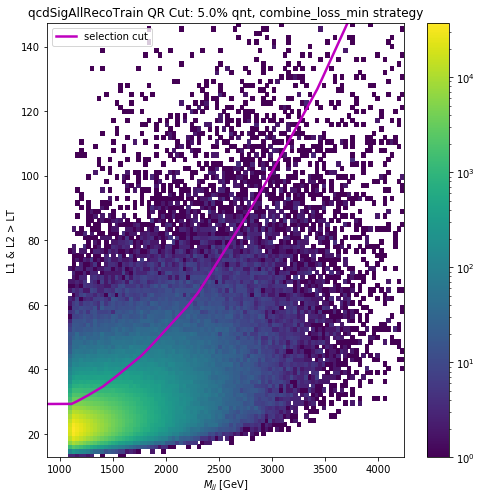

In [7]:
# plot mjj qcd sig to check for flat ratio
an.analyze_discriminator_cut(discriminator, qcd_train)

In [8]:
date = datetime.date.today()
date_str = '{}{:02d}{:02d}'.format(date.year, date.month, date.day)
model_str = str(QR_train_share)+'_qr_train_'+ str(quantile) +'q_'+ date_str
discriminator.save('models/dnn_run_101_{}.h5'.format(model_str))
print(model_str)

0.3_qr_train_0.05q_20200907


## plot mjj accepted vs rejected signal to check for mass sculpting

In [9]:
counting_experiment = {}
bin_edges = [0,1126,1181,1246,1313,1383,1455,1530,1607,1687,1770,1856,1945,2037,2132,2231,2332,2438,2546,2659,2775,2895,3019,3147,3279,3416,3558,3704,3854,4010,4171,4337,4509,4686,4869,5058,5253,5500,5663,5877,6099,6328,6564,6808,1e6]

### qcd training set

min 1100.0001220703125, max 6645.2822265625


Warning in <TH1D::Sumw2>: Sum of squares of weights structure already created
Info in <TCanvas::Print>: jpg file /eos/home-k/kiwoznia/data/VAE_results/bump_hunt_results/run_101/fig/QCD_training_set:_BG_like_vs_SIG_like_mjj_distribution_and_their_ratio.jpg has been created


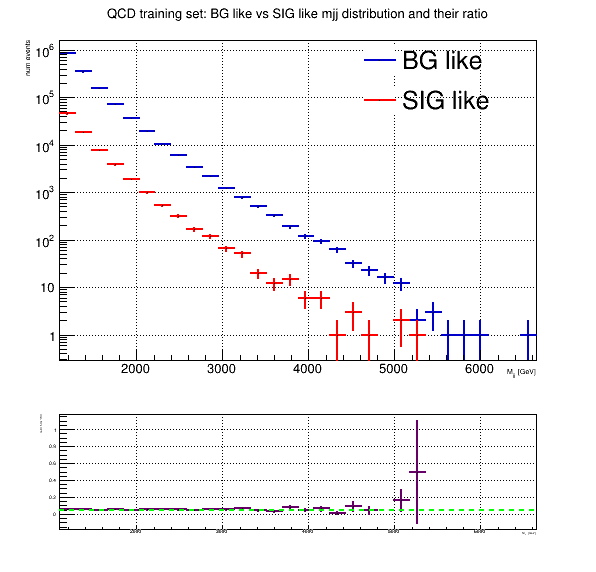

In [10]:
reload(rpu)
selection = discriminator.select(qcd_train)
qcd_train.add_feature('sel', selection)
title = "QCD training set: BG like vs SIG like mjj distribution and their ratio"
h_bg_like_qcd_train, h_sig_like_qcd_train = rpu.make_bg_vs_sig_ratio_plot(qcd_train.rejected(mjj_key), qcd_train.accepted(mjj_key), target_value=quantile, n_bins=30, title=title, fig_dir=experiment.analysis_dir_fig)

### qcd test set

min 1100.0003662109375, max 7338.603515625


Warning in <TH1D::Sumw2>: Sum of squares of weights structure already created
Info in <TCanvas::Print>: jpg file /eos/home-k/kiwoznia/data/VAE_results/bump_hunt_results/run_101/fig/QCD_test_set:_BG_like_vs_SIG_like_mjj_distribution_and_ratio.jpg has been created


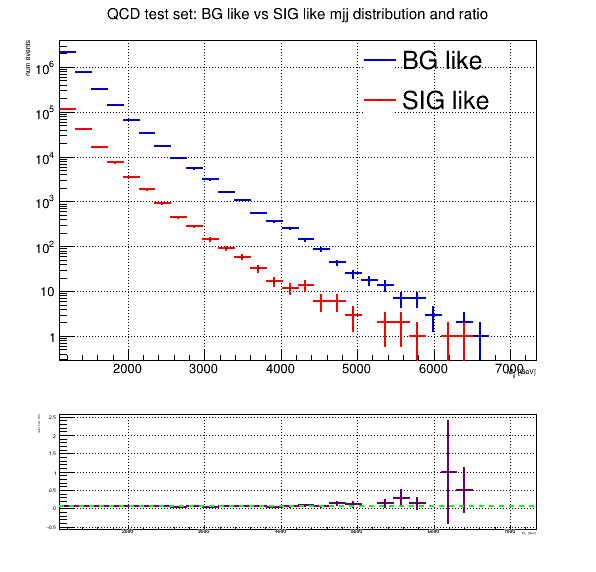

In [11]:
sample = data[SM_sample]
# apply selection to datasample
selection = discriminator.select(sample)
#qcd_sig_test_selected = discriminator.apply(qcd_sig_test)
sample.add_feature('sel', selection)
title = "QCD test set: BG like vs SIG like mjj distribution and ratio"
h_bg_like_qcd_test, h_sig_like_qcd_test = rpu.make_bg_vs_sig_ratio_plot(sample.rejected(mjj_key), sample.accepted(mjj_key), target_value=quantile, n_bins=30, title=title, fig_dir=experiment.analysis_dir_fig)
# save in counts sig like & bg like for qcd SR test set
counting_experiment[SM_sample] = seu.get_bin_counts_sig_like_bg_like(sample, bin_edges)

## check p-value GOF qcd training-set

In [12]:
import dadrah.statistics.hypothesis_test as hypo
reload(hypo)
hypo.hypothesis_test(h_bg_like_qcd_train, h_sig_like_qcd_train, quantile, N_asymov=10000)

S obs: 628.3326318262326
90000 0
Increasing by a factor 5 the number of asymov per loop
Will never have enough stat - giving up.


2.2727272727272728e-06

## check p-value GOF qcd test-set

In [13]:
hypo.hypothesis_test(h_bg_like_qcd_test, h_sig_like_qcd_test, quantile, N_asymov=10000)

S obs: 585.2780005244655
90000 0
Increasing by a factor 5 the number of asymov per loop
Will never have enough stat - giving up.


2.2727272727272728e-06

# apply selection

In [14]:
for sample_id in BSM_samples:
    # apply selection to datasample
    selection = discriminator.select(data[sample_id])
    #qcd_sig_test_selected = discriminator.apply(qcd_sig_test)
    data[sample_id].add_feature('sel', selection)

## print efficiency table 

In [62]:
reload(an)
an.print_discriminator_efficiency_table(data)

+---------------+-------------+
|     Sample    | Eff VAE [%] |
+---------------+-------------+
| qcdSigAllReco |     4.99    |
| GtoWW15naReco |     9.72    |
| GtoWW15brReco |     9.95    |
| GtoWW25naReco |    12.25    |
| GtoWW25brReco |    11.98    |
| GtoWW35naReco |    13.68    |
| GtoWW35brReco |    13.02    |
| GtoWW45naReco |    15.59    |
| GtoWW45brReco |    14.25    |
+---------------+-------------+


# plot mjj ratio

min 1100.00244140625, max 6349.1357421875
min 1100.0020751953125, max 6969.62890625
min 1100.037841796875, max 6329.51171875
min 1100.004150390625, max 8607.81640625
min 1100.159423828125, max 6971.1318359375
min 1100.011474609375, max 10531.125
min 1100.0926513671875, max 7676.17919921875
min 1100.0079345703125, max 9276.2158203125


Warning in <TH1D::Sumw2>: Sum of squares of weights structure already created
Info in <TCanvas::Print>: jpg file /eos/home-k/kiwoznia/data/VAE_results/bump_hunt_results/run_101/fig/GtoWW15naReco:_BG_like_vs_SIG_like_mjj_distribution_and_ratio.jpg has been created
Warning in <TH1D::Sumw2>: Sum of squares of weights structure already created
Info in <TCanvas::Print>: jpg file /eos/home-k/kiwoznia/data/VAE_results/bump_hunt_results/run_101/fig/GtoWW15brReco:_BG_like_vs_SIG_like_mjj_distribution_and_ratio.jpg has been created
Warning in <TH1D::Sumw2>: Sum of squares of weights structure already created
Info in <TCanvas::Print>: jpg file /eos/home-k/kiwoznia/data/VAE_results/bump_hunt_results/run_101/fig/GtoWW25naReco:_BG_like_vs_SIG_like_mjj_distribution_and_ratio.jpg has been created
Warning in <TH1D::Sumw2>: Sum of squares of weights structure already created
Info in <TCanvas::Print>: jpg file /eos/home-k/kiwoznia/data/VAE_results/bump_hunt_results/run_101/fig/GtoWW25brReco:_BG_like_vs_S

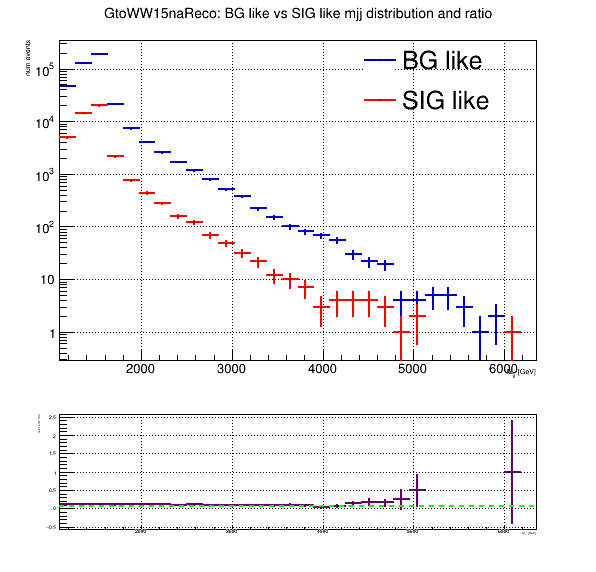

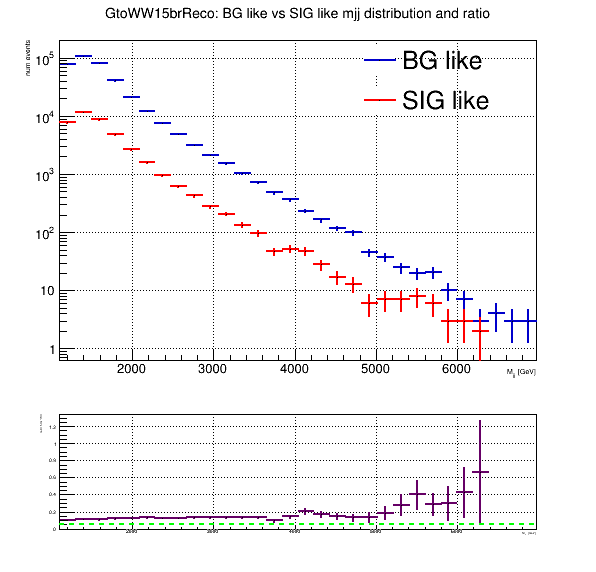

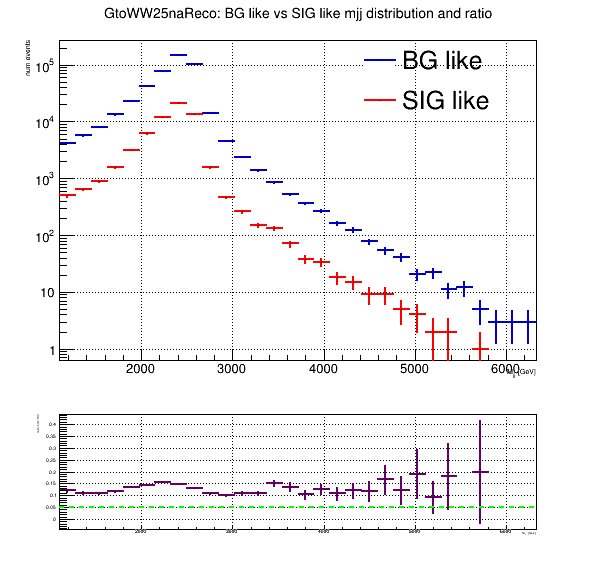

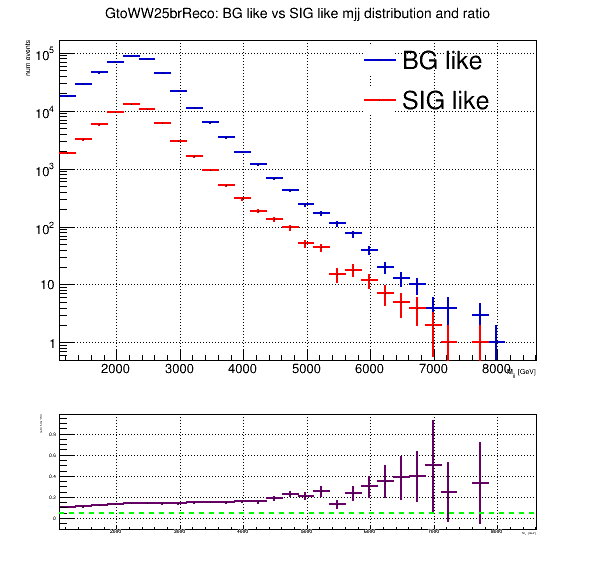

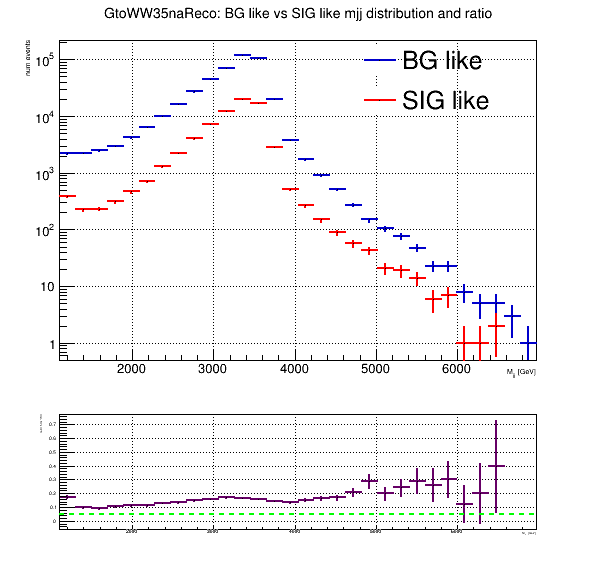

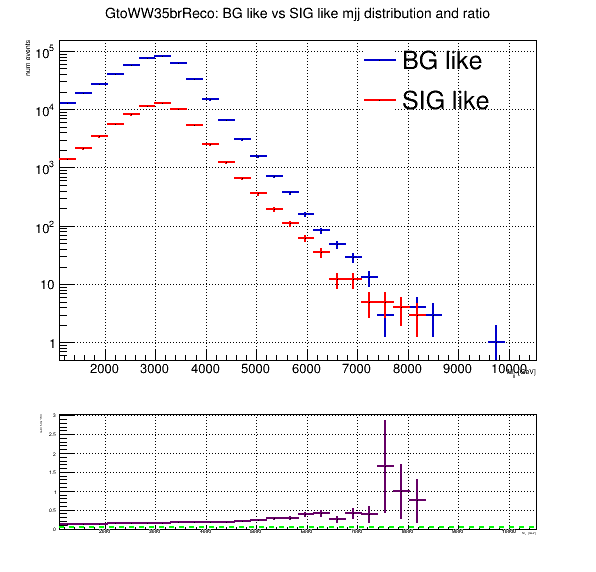

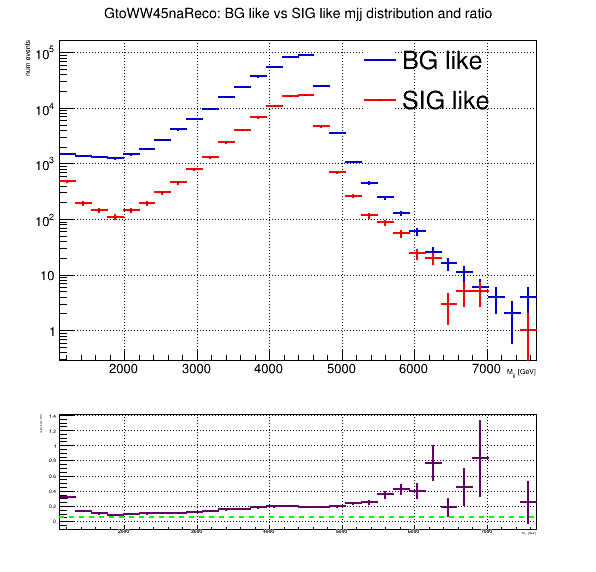

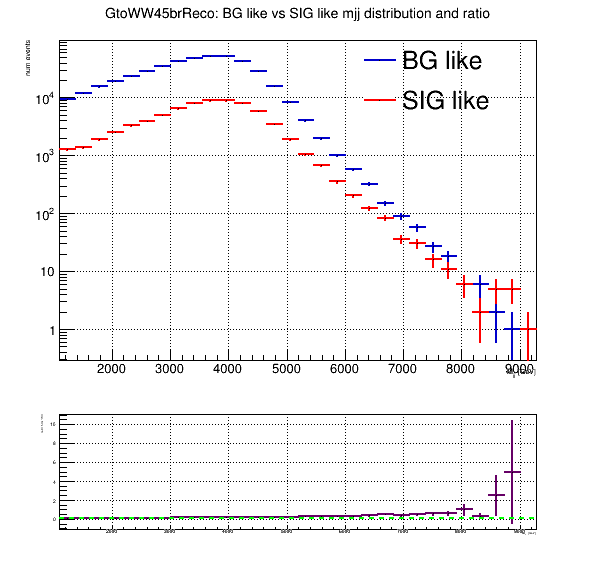

In [16]:
for sample_id in BSM_samples:
    sample = data[sample_id]
    title = sample.name + ": BG like vs SIG like mjj distribution and ratio"
    rpu.make_bg_vs_sig_ratio_plot(sample.rejected(mjj_key), sample.accepted(mjj_key), target_value=quantile, n_bins=30, title=title, fig_dir=experiment.analysis_dir_fig)
    # save in counts sig like & bg like for qcd SR test set
    counting_experiment[sample_id] = seu.get_bin_counts_sig_like_bg_like(sample, bin_edges)

## plot losses (reco vs kl) for accepted and rejected sample

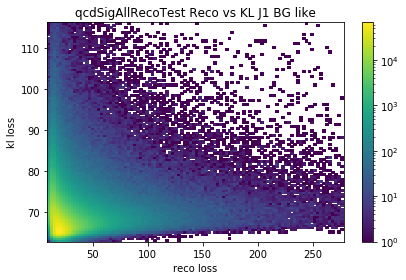

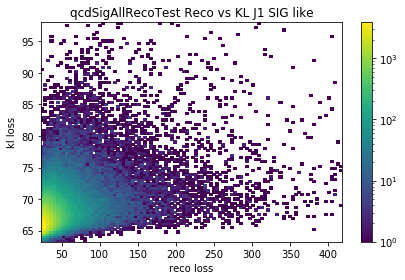

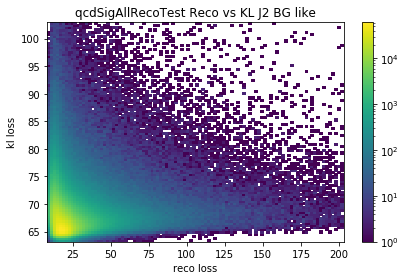

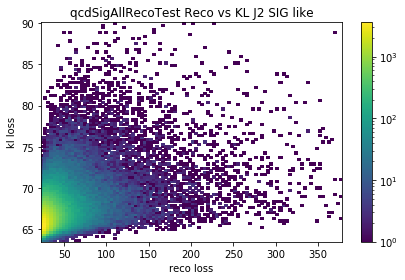

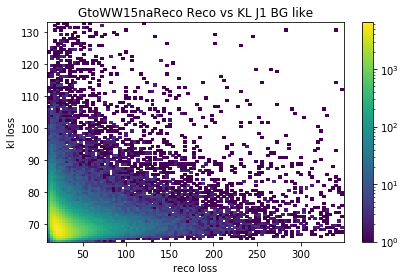

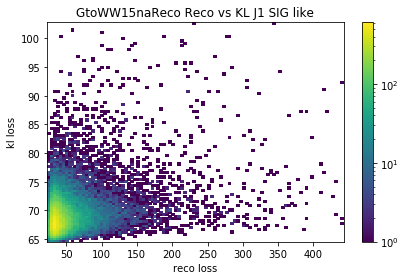

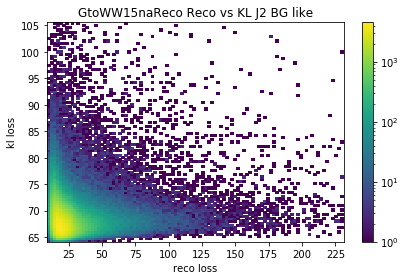

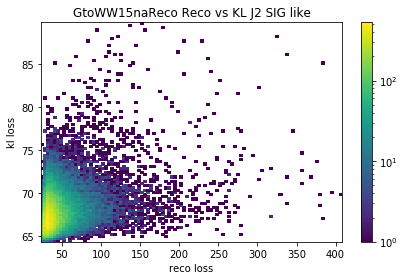

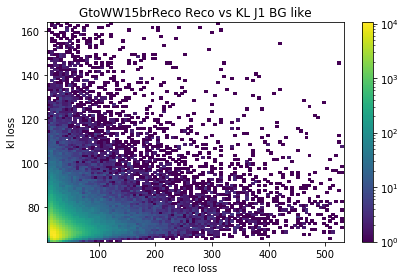

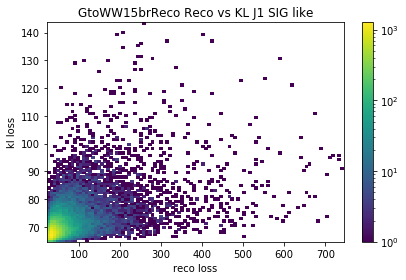

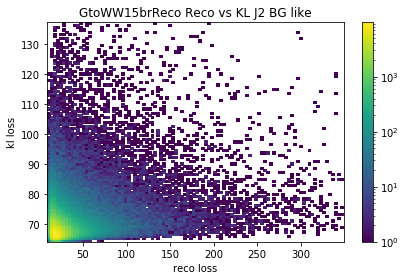

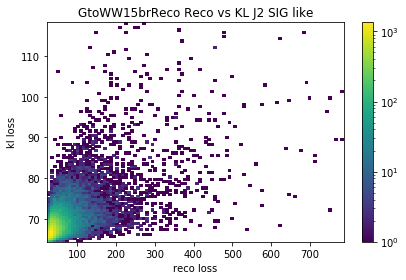

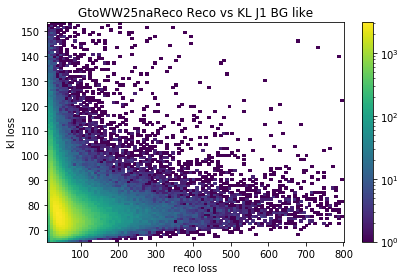

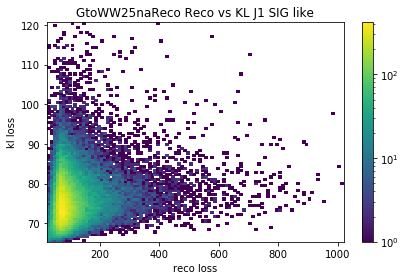

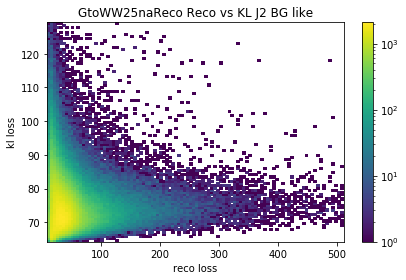

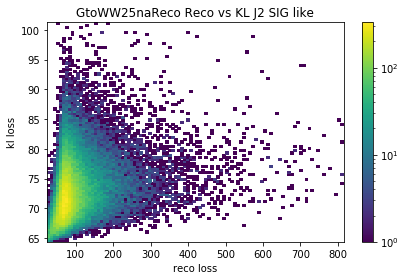

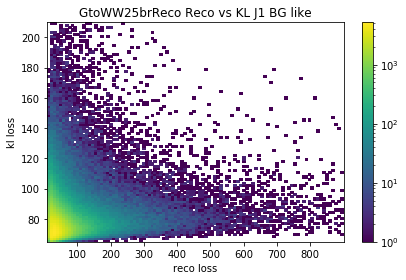

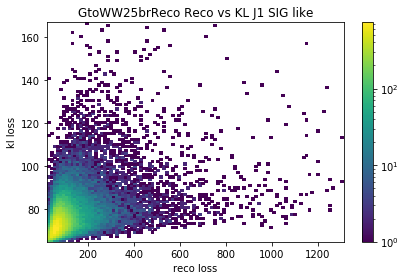

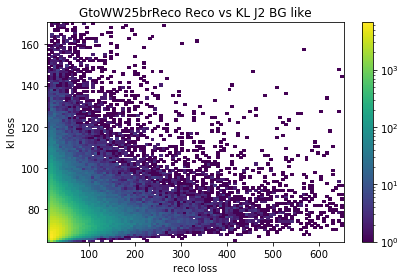

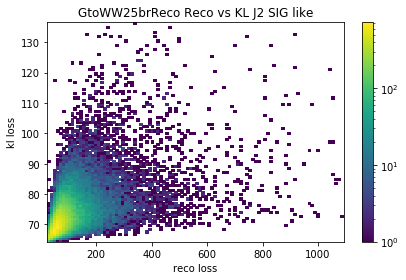

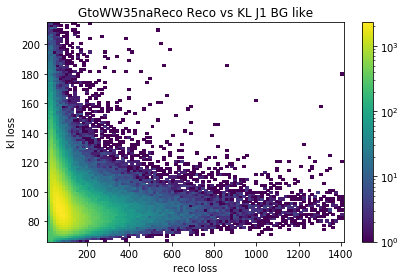

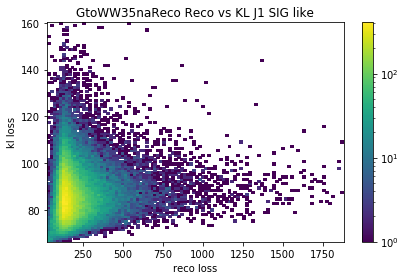

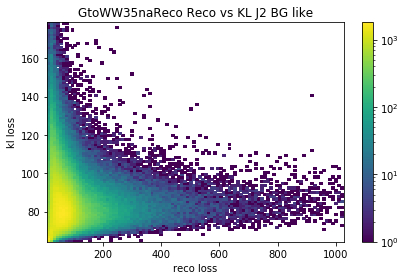

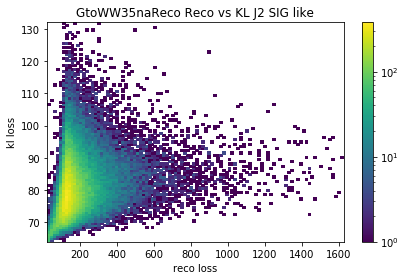

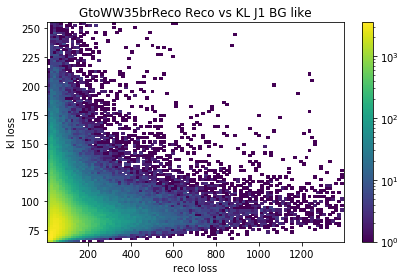

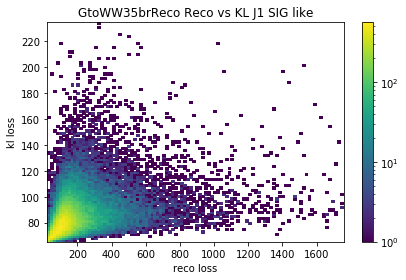

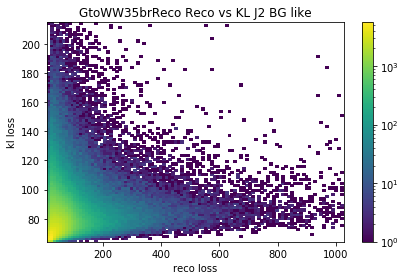

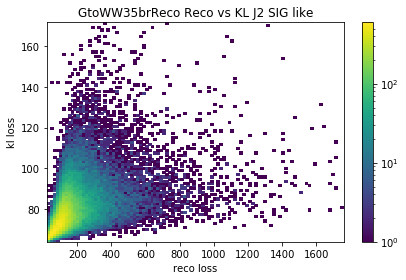

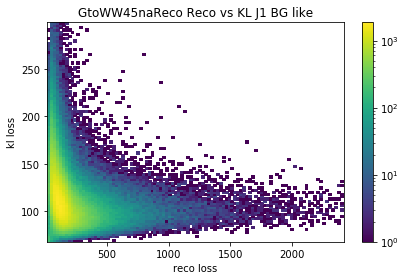

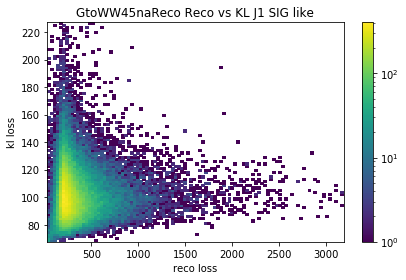

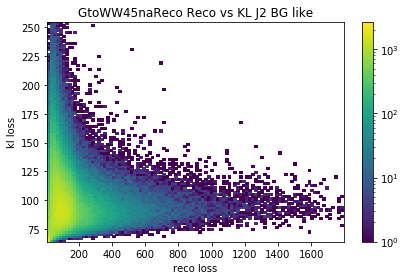

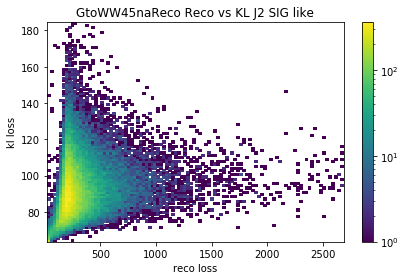

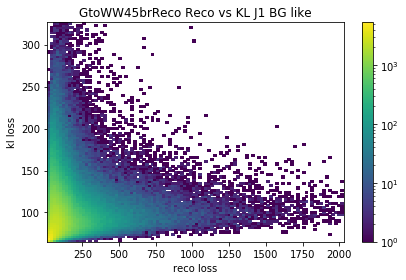

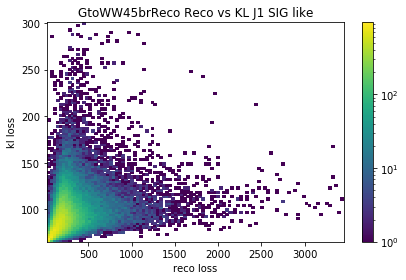

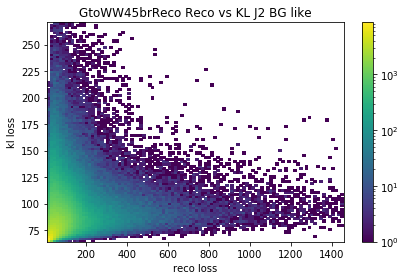

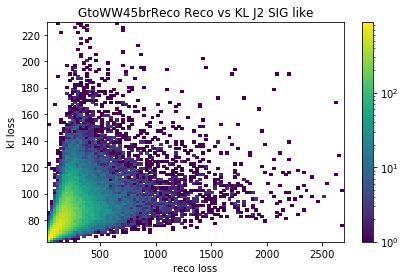

In [17]:
for sample in data.values():
    # plot BG like J1
    pu.plot_hist_2d(sample.rejected('j1RecoLoss'),sample.rejected('j1KlLoss'), xlabel='reco loss', ylabel='kl loss', title=sample.name+' Reco vs KL J1 BG like', clip_outlier=True, fig_dir=experiment.analysis_dir_fig, plot_name=sample.plot_name()+'_RecoVsKLJ1_BGlike.png')
    # plot SIG like J1
    pu.plot_hist_2d(sample.accepted('j1RecoLoss'),sample.accepted('j1KlLoss'), xlabel='reco loss', ylabel='kl loss', title=sample.name+' Reco vs KL J1 SIG like', clip_outlier=True, fig_dir=experiment.analysis_dir_fig, plot_name=sample.plot_name()+'_RecoVsKLJ1_SIGlike.png')
    # plot BG like J2
    pu.plot_hist_2d(sample.rejected('j2RecoLoss'),sample.rejected('j2KlLoss'), xlabel='reco loss', ylabel='kl loss', title=sample.name+' Reco vs KL J2 BG like', clip_outlier=True, fig_dir=experiment.analysis_dir_fig, plot_name=sample.plot_name()+'_RecoVsKLJ2_BGlike.png')
    # plot SIG like J1
    pu.plot_hist_2d(sample.accepted('j2RecoLoss'),sample.accepted('j2KlLoss'), xlabel='reco loss', ylabel='kl loss', title=sample.name+' Reco vs KL J2 SIG like', clip_outlier=True, fig_dir=experiment.analysis_dir_fig, plot_name=sample.plot_name()+'_RecoVsKLJ2_SIGlike.png')
    

In [18]:
print(experiment.analysis_dir)

/eos/home-k/kiwoznia/data/VAE_results/bump_hunt_results/run_101


## write selected samples

In [58]:
import pofah.path_constants.sample_dict_file_parts_selected as sds
result_paths = sf.SamplePathDirFactory(sds.path_dict).extend_base_path(experiment.run_dir)

In [61]:
for sample_id, sample in data.items():
    #print('writing results for {} to {}'.format(sds.path_dict['sample_name'][sample_id], os.path.join(result_paths.sample_dir_path(sample_id), result_paths.sample_file_path(sample_id))))
    sample.dump(os.path.join(result_paths.sample_dir_path(sample_id), result_paths.sample_file_path(sample_id)))


True
True
True
writing results for QCD signalregion all samples reco to /eos/home-k/kiwoznia/data/VAE_results/bump_hunt_results/run_101/selections/qcd_sqrtshatTeV_13TeV_PU40_ALL_parts/qcd_sqrtshatTeV_13TeV_PU40_ALL_reco.h5
written data sample to /eos/home-k/kiwoznia/data/VAE_results/bump_hunt_results/run_101/selections/qcd_sqrtshatTeV_13TeV_PU40_ALL_parts/qcd_sqrtshatTeV_13TeV_PU40_ALL_reco.h5
writing results for $G(1.5 TeV)\to WW$ narrow reco to /eos/home-k/kiwoznia/data/VAE_results/bump_hunt_results/run_101/selections/RSGraviton_WW_NARROW_13TeV_PU40_1.5TeV_parts/RSGraviton_WW_NARROW_13TeV_PU40_1.5TeV_reco.h5
written data sample to /eos/home-k/kiwoznia/data/VAE_results/bump_hunt_results/run_101/selections/RSGraviton_WW_NARROW_13TeV_PU40_1.5TeV_parts/RSGraviton_WW_NARROW_13TeV_PU40_1.5TeV_reco.h5
writing results for $G(1.5 TeV)\to WW$ broad reco to /eos/home-k/kiwoznia/data/VAE_results/bump_hunt_results/run_101/selections/RSGraviton_WW_BROAD_13TeV_PU40_1.5TeV_parts/RSGraviton_WW_BROAD_

## write bin counts to file

In [19]:
reload(reswr)
import os
reswr.write_bin_counts_to_file(counting_experiment, bin_edges, os.path.join(experiment.analysis_dir_bin_count,'sel_bin_count_'+experiment.run_dir+'_tsz'+str(int(QR_train_share*100))+'pc_q'+str(quantile*100)+'.h5'))